# Insurance Fraud Detection: A Machine Learning Model to identify cases automatically
<div style="text-align: center;">
    <img src="markup_title_picture.png" alt="project_picture" width="600">
</div>

### This project aims to develop an intelligent model for insurance fraud detection. Using historical claims that have already been marked as fraudulent or legitimate, a system will be created that is able to automatically identify suspicious patterns, thus efficiently optimizing fraud detection.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import joblib

In [3]:
df = pd.read_csv('damage_reports_EN.csv')
df.head()

,policyholder,contract_date,damage_id,type_of_insurance,damage_date,damage_amount,past_damages,damage_location,involved_persons,fraud
0,K0393,2021-10-09,S00393,car,2022-08-01,648,1,Muenchen,2,False
1,K0718,2021-10-10,S00718,car,2023-10-04,4399,2,Leipzig,1,False
2,K0204,2023-04-01,S00204,contents,2023-08-24,2688,0,Nuernberg,1,False
3,K0405,2021-04-21,S00405,liability,2023-04-11,1250,1,Duesseldorf,1,False
4,K0038,2022-09-12,S00038,car,2023-11-27,1669,2,Hamburg,1,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   policyholder       1000 non-null   object
 1   contract_date      1000 non-null   object
 2   damage_id          1000 non-null   object
 3   type_of_insurance  1000 non-null   object
 4   damage_date        1000 non-null   object
 5   damage_amount      1000 non-null   int64 
 6   past_damages       1000 non-null   int64 
 7   damage_location    1000 non-null   object
 8   involved_persons   1000 non-null   int64 
 9   fraud              1000 non-null   bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 71.4+ KB


## Data Cleaning

In [6]:
df["contract_date"] = pd.to_datetime(df["contract_date"])

In [7]:
df["damage_date"] = pd.to_datetime(df["damage_date"])

## Visualizations

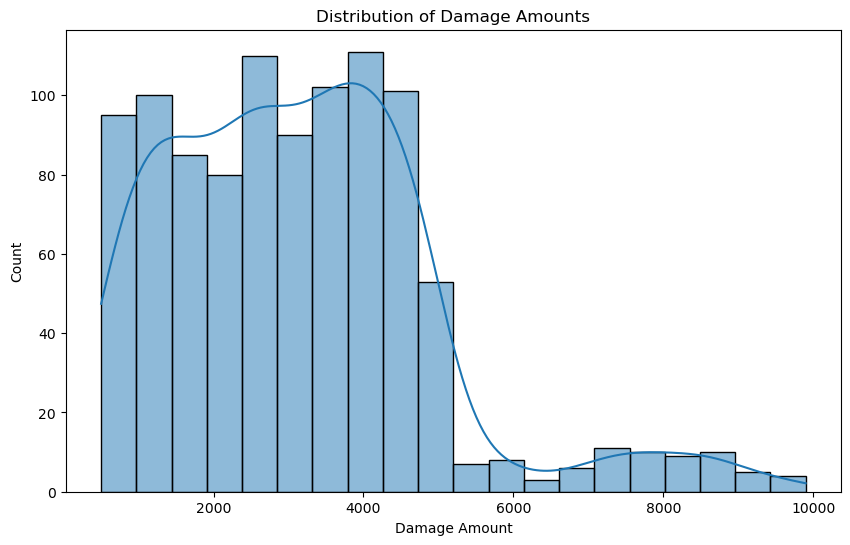

In [9]:
# histplot of damage amounts
plt.figure(figsize=(10, 6))
sns.histplot(df["damage_amount"], kde=True)
plt.title("Distribution of Damage Amounts")
plt.xlabel("Damage Amount")
plt.ylabel("Count")
plt.show()

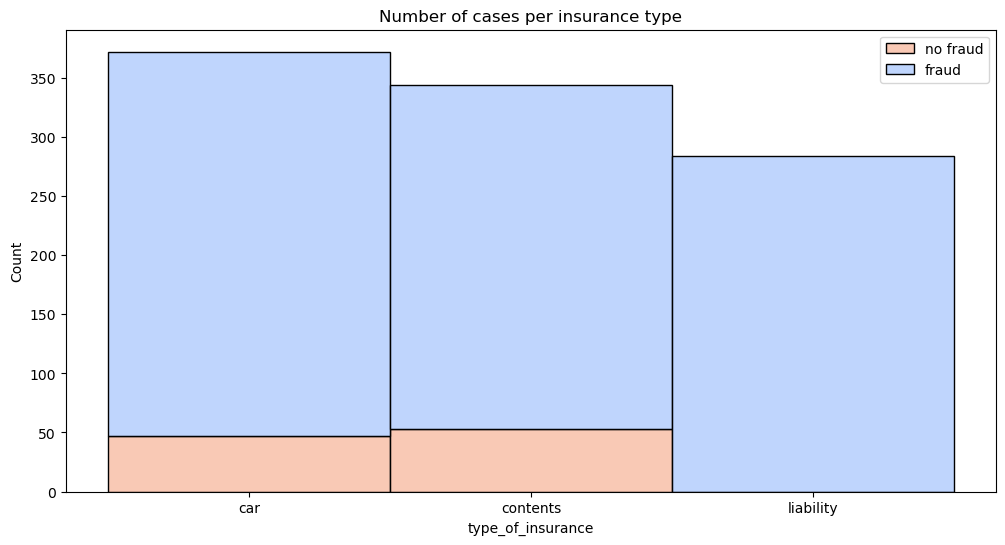

In [10]:
# countplot of insurance types
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="type_of_insurance", hue="fraud", multiple="stack", palette="coolwarm")
plt.title("Number of cases per insurance type")
plt.legend(labels=["no fraud", "fraud"])
plt.show()

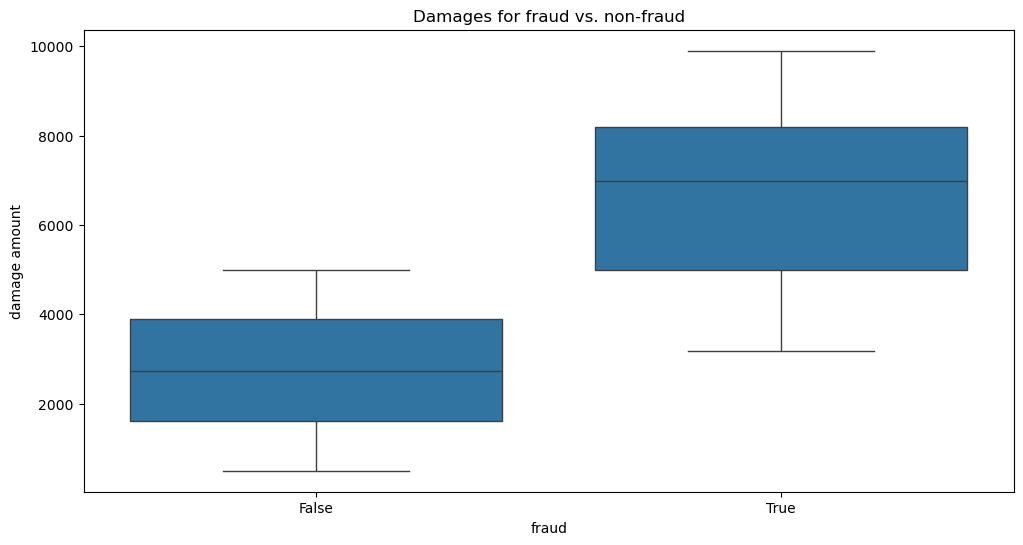

In [11]:
# boxplot to examine the damage amounts between fraud and non-fraud
plt.figure(figsize=(12, 6))
sns.boxplot(x="fraud", y="damage_amount", data=df)
plt.title("Damages for fraud vs. non-fraud")
plt.xlabel("fraud")
plt.ylabel("damage amount")
plt.show()

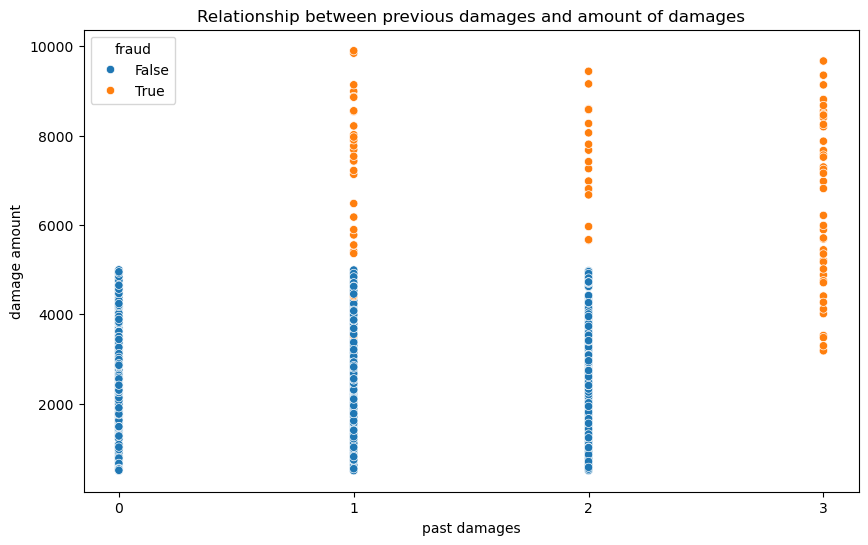

In [12]:
# scatterplot to visualize the relationship between previous damages and damage amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x="past_damages", y="damage_amount", hue="fraud", data=df)
plt.title("Relationship between previous damages and amount of damages")
plt.xticks(ticks=range(df["past_damages"].min(), df["past_damages"].max() + 1))
plt.xlabel("past damages")
plt.ylabel("damage amount")
plt.show()

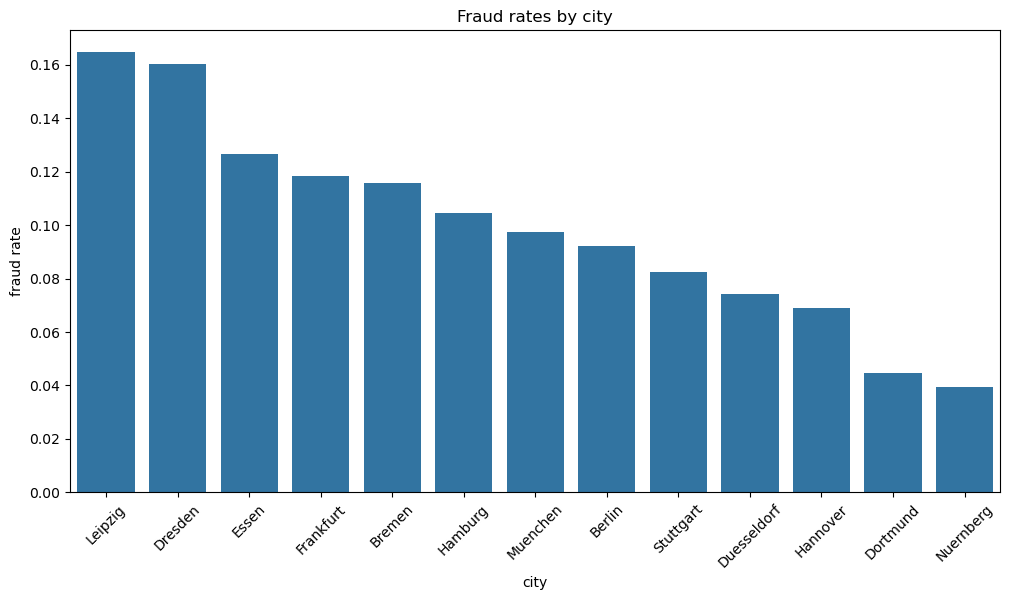

In [13]:
# visualization of fraud rates by city
betrug_staedte = df.groupby("damage_location")["fraud"].mean().reset_index()
betrug_staedte.columns = ["city", "fraud rate"]
betrug_staedte = betrug_staedte.sort_values(by="fraud rate", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x="city", y="fraud rate", data=betrug_staedte)
plt.title("Fraud rates by city")
plt.xticks(rotation=45)
plt.show()

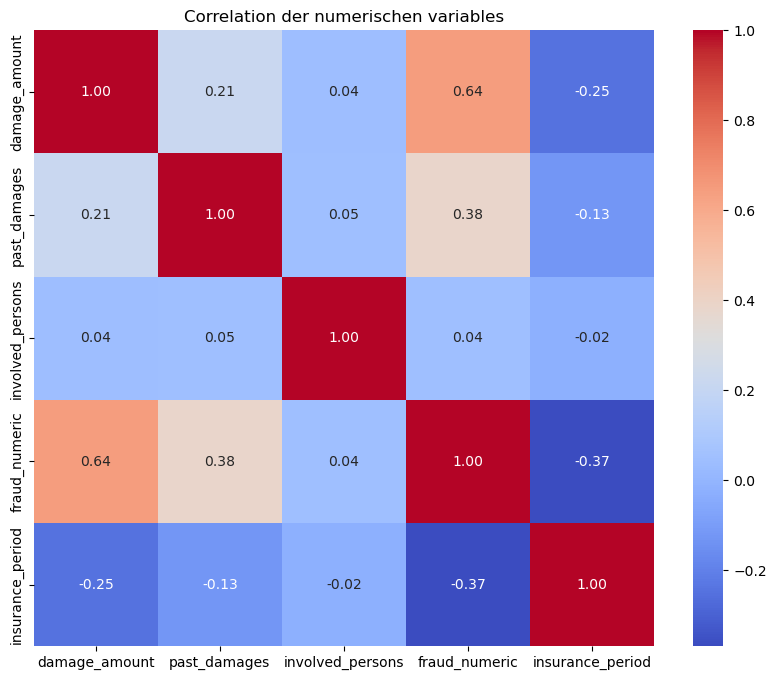

In [14]:
# numerical adjustment of features
df["fraud_numeric"] = df["fraud"].astype(int)
df["insurance_period"] = (df["damage_date"] - df["contract_date"]).dt.days
# heatmap der numeric correlations
numerical_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation der numerischen variables")
plt.show()

## Preparation of modelling

In [16]:
df.head()

,policyholder,contract_date,damage_id,type_of_insurance,damage_date,damage_amount,past_damages,damage_location,involved_persons,fraud,fraud_numeric,insurance_period
0,K0393,2021-10-09,S00393,car,2022-08-01,648,1,Muenchen,2,False,0,296
1,K0718,2021-10-10,S00718,car,2023-10-04,4399,2,Leipzig,1,False,0,724
2,K0204,2023-04-01,S00204,contents,2023-08-24,2688,0,Nuernberg,1,False,0,145
3,K0405,2021-04-21,S00405,liability,2023-04-11,1250,1,Duesseldorf,1,False,0,720
4,K0038,2022-09-12,S00038,car,2023-11-27,1669,2,Hamburg,1,False,0,441


In [17]:
# one-hot encoding for the damage location and the insurance type
df = pd.get_dummies(df, columns=["damage_location", "type_of_insurance"])
df

,policyholder,contract_date,damage_id,damage_date,damage_amount,past_damages,involved_persons,fraud,fraud_numeric,insurance_period,...,damage_location_Frankfurt,damage_location_Hamburg,damage_location_Hannover,damage_location_Leipzig,damage_location_Muenchen,damage_location_Nuernberg,damage_location_Stuttgart,type_of_insurance_car,type_of_insurance_contents,type_of_insurance_liability
0,K0393,2021-10-09,S00393,2022-08-01,648,1,2,False,0,296,...,False,False,False,False,True,False,False,True,False,False
1,K0718,2021-10-10,S00718,2023-10-04,4399,2,1,False,0,724,...,False,False,False,True,False,False,False,True,False,False
2,K0204,2023-04-01,S00204,2023-08-24,2688,0,1,False,0,145,...,False,False,False,False,False,True,False,False,True,False
3,K0405,2021-04-21,S00405,2023-04-11,1250,1,1,False,0,720,...,False,False,False,False,False,False,False,False,False,True
4,K0038,2022-09-12,S00038,2023-11-27,1669,2,1,False,0,441,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,K0347,2022-10-01,S00347,2023-07-23,4453,1,2,False,0,295,...,False,False,False,False,False,False,False,False,True,False
996,K0777,2022-01-30,S00777,2022-10-05,816,1,3,False,0,248,...,False,False,False,False,False,False,False,True,False,False
997,K0338,2022-10-24,S00338,2023-10-27,1779,1,1,False,0,368,...,False,False,False,False,False,False,False,True,False,False
998,K0386,2023-01-14,S00386,2023-03-29,4725,2,1,False,0,74,...,False,False,False,False,False,True,False,False,False,True


In [18]:
# convert the dates into numeric values ​​(days since a certain date)
df["contract_days"] = (df["contract_date"] - pd.to_datetime("2020-01-01")).dt.days
df["damage_days"] = (df["damage_date"] - pd.to_datetime("2020-01-01")).dt.days

# remove the original dates and other irrelevant features
x = df.drop(columns=["fraud", "fraud_numeric", "policyholder", "damage_id", "contract_date", "damage_date"])  # Entferne Datumsangaben und andere nicht relevante Spalten
y = df["fraud"]

# divide the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Training and testing the model

In [20]:
# model training
model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [21]:
# prediction on the test dataset
y_pred = model.predict(x_test)

# evaluation of the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.98
Confusion Matrix:
 [[265   4]
 [  2  29]]
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99       269
        True       0.88      0.94      0.91        31

    accuracy                           0.98       300
   macro avg       0.94      0.96      0.95       300
weighted avg       0.98      0.98      0.98       300



## Analyse und Abspeichern des Modells

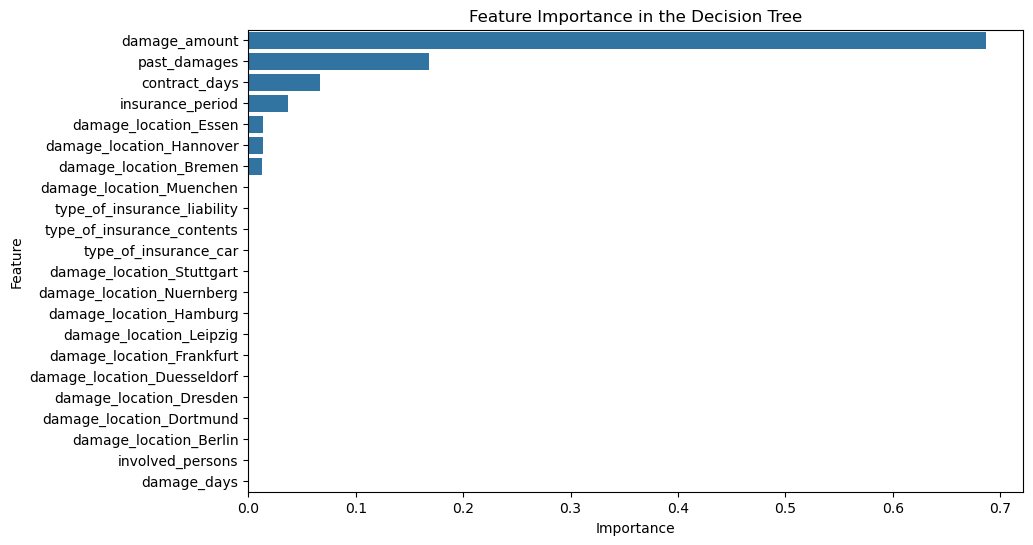

In [23]:
# analysis of the most important features
importances = model.feature_importances_
feature_names = x.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# visualization of feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance in the Decision Tree")
plt.xlabel("Importance")
plt.show()

In [44]:
# saving the trained model
joblib.dump(model, 'decision_tree_model_EN.pkl')

['decision_tree_model_EN.pkl']